# IED forecasting with LightGBM

### Import necessary libraries

In [31]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
from xgboost import plot_importance
from sklearn.utils import compute_sample_weight
from sklearn.metrics import average_precision_score
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split

import joblib
import optuna
import numpy as np
import lightgbm as lgb

In [2]:
# load model
model = joblib.load('lgb.pkl')

FileNotFoundError: [Errno 2] No such file or directory: 'lgb.pkl'

### Load data and split into training, validation and test sets

In [68]:
# X = np.load('ml_data/DaKa/X.npy')
# y = np.load('ml_data/DaKa/y.npy')
# thresh = 3
# channels = 89
# model_dir = 'models/DaKa'
# image_dir = 'images/DaKa'
# train_indices = [3960, 6780, 9600]
# test_indices = [14880, 17640, 20400]

X = np.load('ml_data/BeSa/X.npy')
# y = np.load('ml_data/BeSa/y.npy')

# X = np.load('ml_data/BeSa/X.npy')
y = np.load('baud_y_BeSa.npy')
# y = np.load('baud_y.npy')
# y = np.load('baud_y.npy')

thresh = 2
channels = 106
model_dir = 'models/BeSa'
image_dir = 'images/BeSa'
train_indices = [13200, 23460, 33720]#, 42210, 50640]
test_indices = [50820, 60150, 69480]

#
# X_trainval, X_test = train_test_split(X, test_size=0.2, shuffle=True, random_state=100)
# y_trainval, y_test = train_test_split(y, test_size=0.2, shuffle=True, random_state=100)

# Last hour is test set. Ignore previous hour.
X_trainval, X_test = X[:-7200], X[-3600:]
y_trainval, y_test = y[:-7200], y[-3600:]

In [33]:
y = np.load('ml_data/BeSa/y.npy')

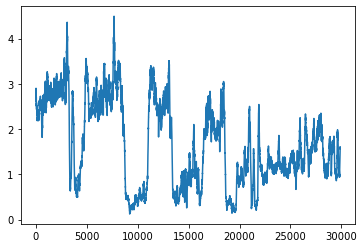

In [67]:
# y = np.load('baud_y_BeSa_20.npy')

N = 120
moving_avg = np.convolve(y, np.ones(N)/N, mode='valid')

plt.plot(moving_avg)

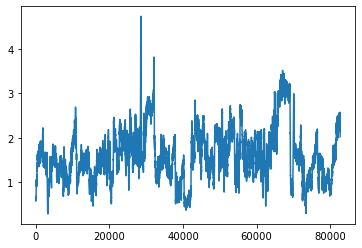

In [33]:
N = 120
moving_avg = np.convolve(y, np.ones(N)/N, mode='valid')

plt.plot(moving_avg)

In [25]:
y_train, y_val = train_test_split(y_trainval, test_size=0.2, shuffle=True)

In [69]:
(y_trainval > thresh).sum() / len(y_trainval)

0.2493286948240056

### Add detections in previous 1 and 5 minutes as features 

In [40]:
def add_detections(X, y, seconds_list=[60, 300]):
    
    X_features_list = [X]
    
    for seconds in seconds_list:
        y_detections = y[:seconds * (len(y) // seconds)].reshape(-1, seconds).sum(axis=-1)
        X_features_list.append(np.append(np.array([0] * seconds), np.repeat(y_detections, seconds))[:len(y)][:, np.newaxis])        

    return np.concatenate(X_features_list, axis=1)

### Define functions for custom AUROC and to get relevant feature subspace, as well as parameters for LightGBM that remain constant, and random seeds

In [41]:
def auroc(y_true, y_pred):
    auroc = roc_auc_score(y_true > thresh, y_pred)
    return 'auroc', auroc, True

def get_features(X, channels, feature_space='full'):
    '''Get a subset of features'''
    
    features = {
        'baseline': X[:, -2:],
        'SEEG': X[:, :-2],
        'no coupling': np.concatenate([X[:, :-2-channels], X[:, -2:]], axis=1),
        'coupled': X[:, -2-channels:-2],
        'full': X,
    }
    
    return features[feature_space]

fixed_params = {
    "objective": "regression",
    "task": "train",
    "is_unbalance": True,
    "eval_metric": [auroc],
    "boosting_type": "gbdt",
    "num_iterations": 100000,
}

seeds = [924, 452, 20, 390, 870]#, 475, 355, 653, 955, 174]

In [42]:
seeds = [390, 870, 475]#, 355, 653, 955, 174]

### Define function to do grid search with optuna

In [13]:
def train_and_optimise(X_train, y_train, X_val, y_val, seed=0, n_trials=100):
    
    def objective(trial):
    
        hyper_params = {
            "learning_rate": trial.suggest_float("learning_rate", 5e-3, 5e-1, log=True),
            "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
            "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 2, 512),
            "max_bin": trial.suggest_int("max_bin", 2, 512),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        }

        eval_set = [(X_val, y_val)]
        
        pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "auroc")

        model = LGBMRegressor(**fixed_params, **hyper_params, metric="custom", seed=seed)

        model.fit(X_train, y_train, \
                  early_stopping_rounds=100, eval_set=eval_set, \
                  eval_metric=[auroc], verbose=False, callbacks=[pruning_callback])

        roc_auc = roc_auc_score(y_val > thresh, model.predict(X_val))
        
        return roc_auc

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    return study

### Perform first set of experiments (pseudo-prospective models)

In [70]:
X_trainval_detected = add_detections(X_trainval, y_trainval, seconds_list=[1, 5, 10, 60, 300])
X_test_detected = add_detections(X_test, y_test, seconds_list=[1, 5, 10, 60, 300])
# X_trainval_detected = add_detections(X_trainval, y_trainval, seconds_list=[60, 300])
# X_test_detected = add_detections(X_test, y_test, seconds_list=[60, 300])

X_train_detected, X_val_detected, y_train, y_val = train_test_split(X_trainval_detected, y_trainval, test_size=0.2, shuffle=True)

# subspaces = ['no coupling', 'baseline', 'full', 'coupled', 'SEEG']
# subspaces = ['baseline', 'SEEG', 'no coupling', 'full']
# subspaces = ['baseline', 'full']
# subspaces = ['baseline']
# subspaces = ['coupling']
subspaces = ['full']

main_scores = []
main_preds = []

for seed in [0]:#seeds:

    curr_scores = []
    curr_preds = []
    
    for subspace in subspaces:
        if seed == 390 and subspace != 'SEEG':
            continue
        
        X_train_ = get_features(X_train_detected, channels, subspace)
        X_val_ = get_features(X_val_detected, channels, subspace)
        X_test_ = get_features(X_test_detected, channels, subspace)

        chosen_model = train_and_optimise(X_train_, y_train, X_val_, y_val, seed=seed, n_trials=10)#0)
        
        model = LGBMRegressor(**fixed_params, **chosen_model.best_params, metric="custom", seed=seed)
        eval_set = [(X_val_, y_val)]

        model.fit(X_train_, y_train, eval_metric=[auroc], early_stopping_rounds=100, \
                  eval_set=eval_set, verbose=False)
        
        score = roc_auc_score(y_test > thresh, model.predict(X_test_))
        
        joblib.dump(model, model_dir + '/main/' + subspace + '_' + str(seed) + '_' + str(score) + '.pkl')
            
        curr_scores.append(score)
        curr_preds.append(model.predict(X_test_))
    
    main_scores.append(curr_scores)
    main_preds.append(curr_preds)

[I 2022-02-28 13:19:43,806] A new study created in memory with name: no-name-1c4b1c61-822f-48a6-adf8-14ec5460da54
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: auroc
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: 0x171e92dc0>
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l1 is set=0.15453202132447508, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15453202132447508
[LightGBM] [Warning] feature_fraction is set=0.3385944222752416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3385944222752416
[LightGBM] [Warning] bagging_fraction is set=0.8785603038025154, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8785603038025154
[LightGBM] [Warning] lambda_l2 is set=5.7860723015187425e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.7860723015187425e-08


[I 2022-02-28 13:23:53,081] Trial 0 finished with value: 0.6941580706300691 and parameters: {'learning_rate': 0.4286255709429211, 'lambda_l1': 0.15453202132447508, 'lambda_l2': 5.7860723015187425e-08, 'num_leaves': 391, 'max_bin': 504, 'feature_fraction': 0.3385944222752416, 'bagging_fraction': 0.8785603038025154, 'bagging_freq': 6, 'min_child_samples': 17}. Best is trial 0 with value: 0.6941580706300691.
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: auroc
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: 0x171e92dc0>
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l1 is set=0.005071484903897783, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005071484903897783
[LightGBM] [Warning] feature_fraction is set=0.8120508373756958, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8120508373756958
[LightGBM] [Warning] bagging_fraction is set=0.7264249661323678, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7264249661323678
[LightGBM] [Warning] lambda_l2 is set=0.00035439093417846505, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00035439093417846505


[I 2022-02-28 13:30:41,869] Trial 1 finished with value: 0.7399363973363068 and parameters: {'learning_rate': 0.005418341815428666, 'lambda_l1': 0.005071484903897783, 'lambda_l2': 0.00035439093417846505, 'num_leaves': 95, 'max_bin': 247, 'feature_fraction': 0.8120508373756958, 'bagging_fraction': 0.7264249661323678, 'bagging_freq': 5, 'min_child_samples': 64}. Best is trial 1 with value: 0.7399363973363068.
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: auroc
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: 0x171e92dc0>
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l1 is set=0.0006666502760349444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006666502760349444
[LightGBM] [Warning] feature_fraction is set=0.9433218454900982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9433218454900982
[LightGBM] [Warning] bagging_fraction is set=0.5754892475921395, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5754892475921395
[LightGBM] [Warning] lambda_l2 is set=6.243236918402212, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.243236918402212


[I 2022-02-28 13:31:59,008] Trial 2 finished with value: 0.7184683925309092 and parameters: {'learning_rate': 0.16071232064091873, 'lambda_l1': 0.0006666502760349444, 'lambda_l2': 6.243236918402212, 'num_leaves': 291, 'max_bin': 256, 'feature_fraction': 0.9433218454900982, 'bagging_fraction': 0.5754892475921395, 'bagging_freq': 7, 'min_child_samples': 67}. Best is trial 1 with value: 0.7399363973363068.
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: auroc
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: 0x171e92dc0>
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l1 is set=0.0017561450031125588, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0017561450031125588
[LightGBM] [Warning] feature_fraction is set=0.6739350900124279, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6739350900124279
[LightGBM] [Warning] bagging_fraction is set=0.637951342382983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.637951342382983
[LightGBM] [Warning] lambda_l2 is set=0.003759341238214425, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003759341238214425


[I 2022-02-28 13:33:55,799] Trial 3 finished with value: 0.7343402887872568 and parameters: {'learning_rate': 0.025583468743986235, 'lambda_l1': 0.0017561450031125588, 'lambda_l2': 0.003759341238214425, 'num_leaves': 445, 'max_bin': 35, 'feature_fraction': 0.6739350900124279, 'bagging_fraction': 0.637951342382983, 'bagging_freq': 6, 'min_child_samples': 59}. Best is trial 1 with value: 0.7399363973363068.
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: auroc
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: 0x171e92dc0>
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l1 is set=5.962984113025779e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.962984113025779e-08
[LightGBM] [Warning] feature_fraction is set=0.9063044575143062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9063044575143062
[LightGBM] [Warning] bagging_fraction is set=0.4906378561062882, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4906378561062882
[LightGBM] [Warning] lambda_l2 is set=0.00017204132586033804, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00017204132586033804


[I 2022-02-28 13:36:46,632] Trial 4 finished with value: 0.7390462876408099 and parameters: {'learning_rate': 0.012984501624411377, 'lambda_l1': 5.962984113025779e-08, 'lambda_l2': 0.00017204132586033804, 'num_leaves': 55, 'max_bin': 373, 'feature_fraction': 0.9063044575143062, 'bagging_fraction': 0.4906378561062882, 'bagging_freq': 4, 'min_child_samples': 66}. Best is trial 1 with value: 0.7399363973363068.
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: auroc
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: 0x171e92dc0>
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=3.1269370871208356e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1269370871208356e-06
[LightGBM] [Warning] feature_fraction is set=0.8709730787852004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8709730787852004
[LightGBM] [Warning] bagging_fraction is set=0.3387472026193378, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3387472026193378
[LightGBM] [Warning] lambda_l2 is set=2.4734106862782624e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4734106862782624e-08


[I 2022-02-28 13:36:57,574] Trial 5 pruned. Trial was pruned at iteration 0.
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[I 2022-02-28 13:37:08,601] Trial 6 pruned. Trial was pruned at iteration 0.
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[I 2022-02-28 13:37:21,968] Trial 7 pruned. Trial was pruned at iteration 0.
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".f

Number of finished trials: 10
Best trial:
  Value: 0.7399363973363068
  Params: 
    learning_rate: 0.005418341815428666
    lambda_l1: 0.005071484903897783
    lambda_l2: 0.00035439093417846505
    num_leaves: 95
    max_bin: 247
    feature_fraction: 0.8120508373756958
    bagging_fraction: 0.7264249661323678
    bagging_freq: 5
    min_child_samples: 64


/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


In [61]:
# DaKa, ['baseline', 'SEEG', 'no coupling', 'full'], [60, 360], labelled by Richard
np.array(main_scores[1:]).mean(axis=0)

array([0.6228969 , 0.74679794, 0.74530756, 0.74364469])

In [63]:
# BeSa, ['baseline', 'SEEG', 'no coupling', 'full'], [60, 360], labelled by Richard
np.array(main_scores[1:]).mean(axis=0)

array([0.53262201, 0.63582756, 0.64314713, 0.64025915])

In [66]:
# DaKa, all features, labelled by Richard, [1,5,60,360]
main_scores

[[0.6517919756544506]]

In [71]:
main_scores

[[0.7499633095976563]]

In [72]:
(0.7499633095976563 + 0.6517919756544506)/2

0.7008776426260535

In [30]:
main_scores

[[0.5704906893182269]]

In [20]:
# BeSa, all features, IEDs labelled by Richard
main_scores

[[0.6377310192362725]]

In [17]:
thresh

2

In [919]:
import os
import time

X_test_detected = add_detections(X_test, y_test, seconds_list=[60, 300])

# subspaces = ['baseline', 'SEEG', 'no coupling', 'full']
# subspaces = ['baseline', 'full']
# subspaces = ['no coupling', 'baseline', 'full', 'coupled', 'SEEG']
subspaces = ['baseline', 'coupled', 'no coupling', 'SEEG', 'full']
# subspaces = ['baseline']

fpr_all = []
tpr_all = []
tprs_all = []
thresh_all = []
main_scores = []
main_models = []
main_importances = []
conf_matrices = []

for subspace in subspaces:
    
    curr_fpr = []
    curr_tpr = []
    curr_tprs = []
    curr_scores = []
    curr_importances = []
    curr_thresh = []
    curr_models = []
    curr_conf_matrix = []

    X_test_ = get_features(X_test_detected, channels, subspace)
    X_val_ = get_features(X_val_detected, channels, subspace)
    
    for file in os.listdir(model_dir + '/main'):
        if subspace in file:
            model = joblib.load(model_dir + '/main/' + file)
            curr_models.append(model)
            
            score = roc_auc_score(y_test > thresh, model.predict(X_test_))
            
            curr_importances.append(model.feature_importances_)
            
            curr_scores.append(score)
            
            fpr, tpr, threshs = roc_curve(y_test > thresh, model.predict(X_test_))
            
            idx_to_use = np.argmax(fpr>=0.1)
            fpr_at_0_6.append(tpr[idx_to_use])
            
            curr_conf_matrix.append(confusion_matrix(y_test > thresh, model.predict(X_test_) > threshs[idx_to_use]))
    
            curr_fpr.append(fpr)
            curr_tpr.append(tpr)
            curr_thresh.append(threshs)
            base_fpr = np.linspace(0, 1, 101)
            tpr = np.interp(base_fpr, fpr, tpr)
            tpr[0] = 0.0
            curr_tprs.append(tpr)
    
    fpr_all.append(curr_fpr)
    tpr_all.append(curr_tpr)
    tprs_all.append(curr_tprs)
    thresh_all.append(curr_thresh)
    main_scores.append(curr_scores)
    main_models.append(curr_models)
    main_importances.append(curr_importances)
    conf_matrices.append(curr_conf_matrix)
    
# ['baseline', 'coupled', 'no coupling', 'SEEG', 'full']

In [926]:
main_models[-1][0]

LGBMRegressor(bagging_fraction=0.8618224860207557, bagging_freq=7,
              eval_metric=[<function auroc at 0x175446a60>],
              feature_fraction=0.4463022456719873, is_unbalance=True,
              lambda_l1=9.188223907438834, lambda_l2=1.4733634335249183e-05,
              learning_rate=0.0085002772652915, max_bin=235, metric='custom',
              min_child_samples=7, num_iterations=100000, num_leaves=72,
              objective='regression', seed=20, task='train')

In [899]:
2*(13+channels*(6))+2+channels

1185

In [898]:
np.vstack((np.array(main_importances)[4])).mean(axis=0).argsort()[::-1][:10]

/var/folders/s8/yc5ds6dn11ncxwggkx3c6wrc0000gn/T/ipykernel_60154/3379396772.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.vstack((np.array(main_importances)[4])).mean(axis=0).argsort()[::-1][:10]


array([1183, 1184,  262,  897,  867,  903,  894,  808,  340,  320])

In [903]:
13+6*channels+13+6*channels+channels+2

1094

In [907]:
867-560

307

In [909]:
(867-560) % 6

1

In [ ]:
np.array(main_importances[4]).mean(axis=0)[13:13+channels*6].reshape(6, -1).max(axis=1)

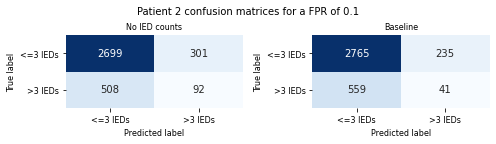

In [725]:
besa_conf = np.array(conf_matrices)[-2].mean(axis=0)
pac_conf = np.array(conf_matrices)[0].mean(axis=0)
produce_confusion_matrices('Patient 2 confusion matrices for a FPR of 0.1', besa_conf, pac_conf)

In [721]:
import seaborn as sns

def produce_confusion_matrices(title, baseline_conf_mat, masked_conf_mat, save_as='conf_mat.pdf'):
    plt.rcParams['figure.figsize']=(7,2)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    sns.heatmap(np.round(baseline_conf_mat), annot=True, cbar=False, cmap="Blues", fmt='g', ax=ax1);  #annot=True to annotate cells, ftm='g' to disable scientific notation
    sns.heatmap(np.round(masked_conf_mat), annot=True, cbar=False, cmap="Blues", fmt='g', ax=ax2);  #annot=True to annotate cells, ftm='g' to disable scientific notation
    for ax in (ax1, ax2):
        ax.set_xlabel('Predicted label', fontdict={'size':8}); ax.set_ylabel('True label', fontdict={'size':8})
        ax.xaxis.set_ticklabels(['<=3 IEDs', '>3 IEDs'], fontsize=8)
        ax.yaxis.set_ticklabels(['<=3 IEDs', '>3 IEDs'], fontsize=8, rotation=0)
        ax1.set_title('No IED counts', fontdict={'size':8})
        ax2.set_title('Baseline', fontdict={'size':8})
    fig.suptitle(title, fontsize=10)
    fig.tight_layout()
    fig.subplots_adjust(top=0.78)
    plt.savefig(image_dir + '/conf_matrix.pdf')

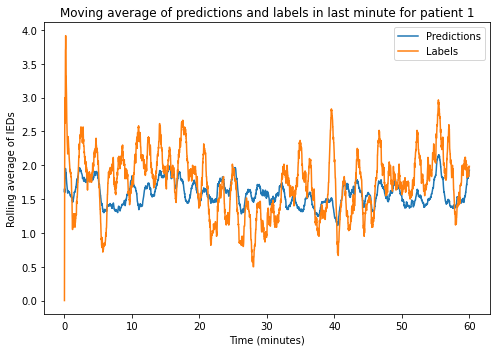

In [308]:
# X_test_ = get_features(X_test_detected, channels, 'SEEG')
# X_test_ = get_features(X_test_detected, channels, 'no coupling')

model = joblib.load(model_dir + '/main/SEEG_452_0.6004127777777778.pkl')
# model = joblib.load(model_dir + '/main/no coupling_452_0.7993516261710717.pkl')

fig = plt.figure()
ax = fig.add_subplot(111)
N = 60
cumsum_true, moving_ave_true = [0], []
cumsum_pred, moving_ave_pred = [0], []

for i, x in enumerate(model.predict(X_test_), 1):
    cumsum_pred.append(cumsum_pred[i-1] + x)
    if i>=N:
        moving_ave = (cumsum_pred[i] - cumsum_pred[i-N])/N
    else:
        moving_ave = cumsum_pred[i] / i
    moving_ave_pred.append(moving_ave)
    
for i, x in enumerate(y_test, 1):
    cumsum_true.append(cumsum_true[i-1] + x)
    if i>=N:
        moving_ave = (cumsum_true[i] - cumsum_true[i-N])/N
    else:
        moving_ave = cumsum_true[i] / i
    moving_ave_true.append(moving_ave)

ax.plot([second/60 for second in range(len(moving_ave_pred))], moving_ave_pred, label='Predictions')
ax.plot([second/60 for second in range(len(moving_ave_true))], moving_ave_true, label='Labels')
ax.set_ylabel('Rolling average of IEDs')
ax.set_xlabel('Time (minutes)')
ax.legend()
plt.title('Moving average of predictions and labels in last minute for patient 1')
plt.tight_layout()
plt.savefig(image_dir + '/moving_average.pdf')
plt.show()

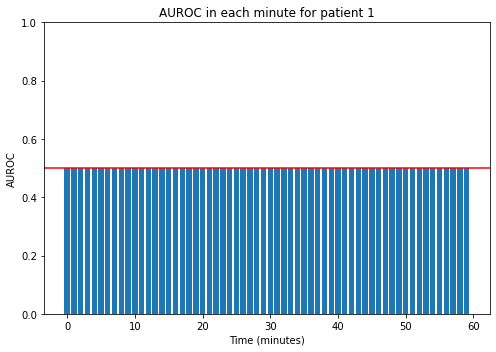

1.0

In [484]:
fig = plt.figure()
ax = fig.add_subplot(111)

roc_scores = []
preds = model.predict(X_test_)

for i in range(int(len(y_test) / 60)):
    if (y_test[i * 60:(i+1) * 60] > thresh).sum() == 0:
        roc_scores.append(0.5)
    else:
        roc_scores.append(roc_auc_score(y_test[i * 60:(i+1) * 60] > thresh, preds[i * 60:(i+1) * 60]))
ax.bar(range(len(roc_scores)), roc_scores)
ax.axhline(y=0.5, color='r', linestyle='-')
ax.set_ylabel('AUROC')
ax.set_xlabel('Time (minutes)')
plt.ylim([0, 1])
plt.title('AUROC in each minute for patient 1')
plt.tight_layout()
plt.savefig(image_dir + '/auroc_over_time.pdf')

plt.show()
len([roc for roc in roc_scores if roc >= 0.5]) / len(roc_scores)

In [498]:
np.array(main_importances[4]).mean(axis=0)[13:13+channels*6].reshape(6, -1).max(axis=1)

array([ 76. ,  65.2, 116.8,  93. ,  56. ,  69.2])

In [491]:
np.array(main_importances[3]).mean(axis=0)[13:13+channels*6].reshape(6, -1).max(axis=1)

IndexError: list index out of range

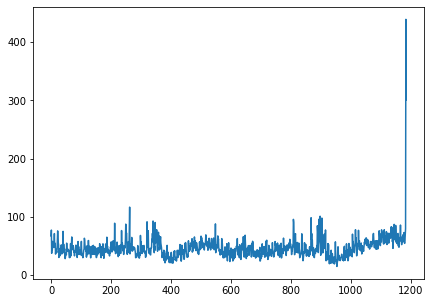

In [151]:
plt.plot(np.array((main_importances[4])).mean(axis=0))

In [481]:
# fpr_all[-1], tpr_all[-1]

# index_of_0_6 = 
# np.argmax(np.array(fpr_all[-1][0])>=0.6)

# tpr_all[-1][0][699]

# fpr_all[-1], tpr_all[-1]
fpr_at_0_6 = []
for fpr, tpr in zip(fpr_all[-2], tpr_all[-2]):
    test = np.argmax(tpr>=0.6)
    fpr_at_0_6.append(fpr[test])
    
print(np.mean(fpr_at_0_6))

0.4695333333333333


In [514]:
fpr_at_0_6 = []
ideal_thresholds = []

for fpr, tpr, thresh in zip(np.array(fpr_all)[:, idx], np.array(tpr_all)[:, idx], np.array(thresh_all)[:, idx]):
    test = np.argmax(tpr>=0.6)
    fpr_at_0_6.append(fpr[test])
    ideal_thresholds.append(thresh[test])

/var/folders/s8/yc5ds6dn11ncxwggkx3c6wrc0000gn/T/ipykernel_60154/3529521193.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for fpr, tpr, thresh in zip(np.array(fpr_all)[:, idx], np.array(tpr_all)[:, idx], np.array(thresh_all)[:, idx]):


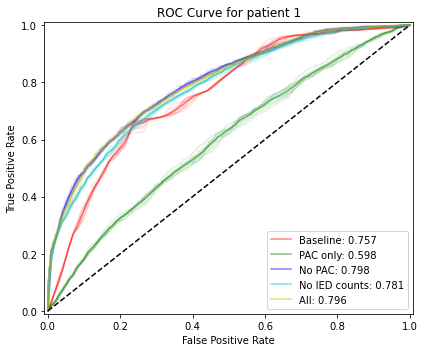

In [715]:
from matplotlib.pyplot import figure
figure(figsize=(6, 5))#, dpi=80)
colours = ['r', 'g', 'b', 'c', 'y']

plt.rcParams['figure.figsize']=(7,5)
base_fpr = np.linspace(0, 1, 101)

aurocs = np.mean(main_scores, axis=1)

# subspaces = ['no coupling', 'baseline', 'full', 'coupled', 'SEEG']
subspaces = ['baseline', 'coupled', 'no coupling', 'SEEG', 'full']

# subspace_labels = ['No PAC', 'Baseline', 'Full', 'PAC only', 'SEEG only']
subspace_labels = ['Baseline', 'PAC only', 'No PAC', 'No IED counts', 'All']
auroc_mapping = [1, 3, 0, 4, 2]

for i, subspace in enumerate(subspaces):
    
    for fpr, tpr in zip(fpr_all[i], tpr_all[i]):
        plt.plot(fpr, tpr, colours[i], alpha=0.1)

    tprs = np.array(tprs_all[i])
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std

    baseline_label = subspace_labels[i] + ': ' + str(np.around(aurocs[i], decimals=3))#subspace#"test"#f'Baseline: {baseline_auc:.3f} [{baseline_auc_bounds[0]:.3f}, {baseline_auc_bounds[1]:.3f}]'
    plt.plot(base_fpr, mean_tprs, c=colours[i], label=baseline_label, alpha=0.5)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color=colours[i], alpha=0.1)

plt.plot([0, 1], [0, 1], '--', c='black')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tight_layout()
plt.legend()
plt.title('ROC Curve for patient 1')
plt.tight_layout()
plt.savefig(image_dir + '/ROC_main.pdf')
plt.show()

In [253]:
from scipy.stats import mannwhitneyu
# generate two independent samples
data1 = np.array(main_scores)[2]
data2 = np.array(main_scores)[4]
# data2 = np.array(main_scores)[4]
# compare samples
stat, p = mannwhitneyu(data1, data2)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distribution (fail to reject H0)')
else:
	print('Different distribution (reject H0)')

Statistics=9.000, p=0.548
Same distribution (fail to reject H0)


In [254]:
from scipy.stats import mannwhitneyu
# generate two independent samples
data1 = np.array(main_scores_besa)[2]
data2 = np.array(main_scores_besa)[4]
# compare samples
stat, p = mannwhitneyu(data1, data2)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distribution (fail to reject H0)')
else:
	print('Different distribution (reject H0)')

Statistics=21.000, p=0.095
Same distribution (fail to reject H0)


In [93]:
np.mean(main_scores, axis=0)

array([0.75159216, 0.79740958])

In [276]:
np.mean(main_scores, axis=0)

array([0.75695286, 0.78145362, 0.79805003, 0.79585936, 0.59830987])

In [17]:
#baseline, SEEG, no coupling, full
np.mean(main_scores, axis=0)

array([0.73517901, 0.73816879])

In [43]:
np.stack((main_models[0][1].feature_importances_, main_models[1][1].feature_importances_)).mean(axis=0).argsort()[::-1][:10]

array([1404,  259,  856, 1405,  698, 1047, 1260, 1375,  660,  586])

### Perform final set of experiments (considering cycle lengths)

In [74]:
cycle_scores = []
cycle_preds = []

for seed in seeds:

    curr_scores = []
    curr_preds = []
    
    for i in range(3):
        
        X_trainval_partition = X_trainval[train_indices[i % 2]:train_indices[(i + 3) // 2]]
        y_trainval_partition = y_trainval[train_indices[i % 2]:train_indices[(i + 3) // 2]]
        X_trainval_partition = add_detections(X_trainval_partition, y_trainval_partition, seconds_list=[60, 300])

        X_train_partition, X_val_partition, y_train_partition, y_val_partition = \
        train_test_split(X_trainval_partition, y_trainval_partition, test_size=0.2, shuffle=True)

        chosen_model = train_and_optimise(X_train_partition, y_train_partition, \
                                          X_val_partition, y_val_partition, seed=seed, n_trials=100)

        model = LGBMRegressor(**fixed_params, **chosen_model.best_params, metric="custom", seed=seed)
        eval_set = [(X_val_partition, y_val_partition)]

        model.fit(X_train_partition, y_train_partition, eval_metric=[auroc], \
                  early_stopping_rounds=100, eval_set=eval_set, verbose=False)
                
        for j in range(3):
            
            X_test_partition = X_trainval[test_indices[j % 2]:test_indices[(j + 3) // 2]]
            y_test_partition = y_trainval[test_indices[j % 2]:test_indices[(j + 3) // 2]]
            X_test_partition = add_detections(X_test_partition, y_test_partition, seconds_list=[60, 300])

            score = roc_auc_score(y_test_partition > thresh, model.predict(X_test_partition))
            curr_scores.append(score)
            curr_preds.append(model.predict(X_test_partition))
            print("SCORE", i, j, score)
            
        joblib.dump(model, model_dir + '/cycles/' + str(i) + '_' + str(seed) + '.pkl')

    cycle_scores.append(curr_scores)
    cycle_preds.append(curr_preds)

[I 2021-08-31 04:36:54,881] A new study created in memory with name: no-name-70f6502f-b294-47e4-86bf-0f3a74b27f28
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: auroc
[LightGBM] [Warning] Unknown parameter: 0x171797af0>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.8592571794201265, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8592571794201265
[LightGBM] [Warning] bagging_fraction is set=0.6676384969317362, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6676384969317362
[LightGBM] [Warning] lambda_l2 is set=3.1926691046239437e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1926691046239437e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l1 is set=2.927735660879695e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.927735660879695e-05


[I 2021-08-31 04:36:56,959] Trial 0 finished with value: 0.6435203785545288 and parameters: {'learning_rate': 0.1798523553836924, 'lambda_l1': 2.927735660879695e-05, 'lambda_l2': 3.1926691046239437e-07, 'num_leaves': 123, 'max_bin': 72, 'feature_fraction': 0.8592571794201265, 'bagging_fraction': 0.6676384969317362, 'bagging_freq': 7, 'min_child_samples': 86}. Best is trial 0 with value: 0.6435203785545288.
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: auroc
[LightGBM] [Warning] Unknown parameter: 0x171797af0>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.8214466981186346, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8214466981186346
[LightGBM] [Warning] bagging_fraction is set=0.8325006091982337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8325006091982337
[LightGBM] [Warning] lambda_l2 is set=0.8677393968523938, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8677393968523938
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l1 is set=1.2811071693143873e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2811071693143873e-06


[I 2021-08-31 04:37:08,374] Trial 1 finished with value: 0.6956981087153846 and parameters: {'learning_rate': 0.005468601727762225, 'lambda_l1': 1.2811071693143873e-06, 'lambda_l2': 0.8677393968523938, 'num_leaves': 299, 'max_bin': 374, 'feature_fraction': 0.8214466981186346, 'bagging_fraction': 0.8325006091982337, 'bagging_freq': 3, 'min_child_samples': 55}. Best is trial 1 with value: 0.6956981087153846.
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: auroc
[LightGBM] [Warning] Unknown parameter: 0x171797af0>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.9214198407998087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9214198407998087
[LightGBM] [Warning] bagging_fraction is set=0.629475526109813, subsample=1.0 will be ignored. Current value: bagging_fraction=0.629475526109813
[LightGBM] [Warning] lambda_l2 is set=0.0005885659703817041, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005885659703817041
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.14320031256060914, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14320031256060914


[I 2021-08-31 04:37:12,827] Trial 2 finished with value: 0.690028718955999 and parameters: {'learning_rate': 0.02089953741825294, 'lambda_l1': 0.14320031256060914, 'lambda_l2': 0.0005885659703817041, 'num_leaves': 119, 'max_bin': 118, 'feature_fraction': 0.9214198407998087, 'bagging_fraction': 0.629475526109813, 'bagging_freq': 1, 'min_child_samples': 43}. Best is trial 1 with value: 0.6956981087153846.
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: auroc
[LightGBM] [Warning] Unknown parameter: 0x171797af0>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.8661671992312645, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8661671992312645
[LightGBM] [Warning] bagging_fraction is set=0.3035623777247972, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3035623777247972
[LightGBM] [Warning] lambda_l2 is set=0.00021944635221157906, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00021944635221157906
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l1 is set=4.0123579913227235e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.0123579913227235e-06


[I 2021-08-31 04:37:19,133] Trial 3 finished with value: 0.6199574423760844 and parameters: {'learning_rate': 0.3488908386631346, 'lambda_l1': 4.0123579913227235e-06, 'lambda_l2': 0.00021944635221157906, 'num_leaves': 353, 'max_bin': 130, 'feature_fraction': 0.8661671992312645, 'bagging_fraction': 0.3035623777247972, 'bagging_freq': 5, 'min_child_samples': 6}. Best is trial 1 with value: 0.6956981087153846.
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: auroc
[LightGBM] [Warning] Unknown parameter: 0x171797af0>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.9921812107211685, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9921812107211685
[LightGBM] [Warning] bagging_fraction is set=0.7580971561416763, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7580971561416763
[LightGBM] [Warning] lambda_l2 is set=7.812901606655629, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.812901606655629
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=2.99963833014891e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.99963833014891e-06


[I 2021-08-31 04:37:27,339] Trial 4 finished with value: 0.6743746558933381 and parameters: {'learning_rate': 0.10184914098130446, 'lambda_l1': 2.99963833014891e-06, 'lambda_l2': 7.812901606655629, 'num_leaves': 314, 'max_bin': 27, 'feature_fraction': 0.9921812107211685, 'bagging_fraction': 0.7580971561416763, 'bagging_freq': 1, 'min_child_samples': 5}. Best is trial 1 with value: 0.6956981087153846.
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: auroc
[LightGBM] [Warning] Unknown parameter: 0x171797af0>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.7724936283847639, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7724936283847639
[LightGBM] [Warning] bagging_fraction is set=0.9300259771456345, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9300259771456345
[LightGBM] [Warning] lambda_l2 is set=2.838641172121949e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.838641172121949e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l1 is set=0.0017633177868369978, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0017633177868369978


[I 2021-08-31 04:37:28,362] Trial 5 pruned. Trial was pruned at iteration 0.
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[I 2021-08-31 04:37:29,416] Trial 6 pruned. Trial was pruned at iteration 0.
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[I 2021-08-31 04:37:30,125] Trial 7 pruned. Trial was pruned at iteration 0.
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".f

Number of finished trials: 10
Best trial:
  Value: 0.6956981087153846
  Params: 
    learning_rate: 0.005468601727762225
    lambda_l1: 1.2811071693143873e-06
    lambda_l2: 0.8677393968523938
    num_leaves: 299
    max_bin: 374
    feature_fraction: 0.8214466981186346
    bagging_fraction: 0.8325006091982337
    bagging_freq: 3
    min_child_samples: 55
SCORE 0 0 0.6306164522364482
SCORE 0 1 0.6532554018899979
SCORE 0 2 0.6479200937950937


[I 2021-08-31 04:37:44,212] A new study created in memory with name: no-name-c3dea3d6-e5d9-488c-8a5f-2498361bc7be
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: auroc
[LightGBM] [Warning] Unknown parameter: 0x171797af0>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.6982162006514665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6982162006514665
[LightGBM] [Warning] bagging_fraction is set=0.2939653052811583, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2939653052811583
[LightGBM] [Warning] lambda_l2 is set=1.6528621628841796e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6528621628841796e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l1 is set=0.0008925699907104378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008925699907104378


[I 2021-08-31 04:37:46,551] Trial 0 finished with value: 0.7203506432715359 and parameters: {'learning_rate': 0.012184087158339588, 'lambda_l1': 0.0008925699907104378, 'lambda_l2': 1.6528621628841796e-06, 'num_leaves': 41, 'max_bin': 18, 'feature_fraction': 0.6982162006514665, 'bagging_fraction': 0.2939653052811583, 'bagging_freq': 5, 'min_child_samples': 70}. Best is trial 0 with value: 0.7203506432715359.
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: auroc
[LightGBM] [Warning] Unknown parameter: 0x171797af0>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.6537882706314779, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6537882706314779
[LightGBM] [Warning] bagging_fraction is set=0.38280604269154894, subsample=1.0 will be ignored. Current value: bagging_fraction=0.38280604269154894
[LightGBM] [Warning] lambda_l2 is set=0.00019128582558742538, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019128582558742538
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l1 is set=8.49861809446559, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.49861809446559


[I 2021-08-31 04:37:48,576] Trial 1 finished with value: 0.6935417523652818 and parameters: {'learning_rate': 0.2760798120031699, 'lambda_l1': 8.49861809446559, 'lambda_l2': 0.00019128582558742538, 'num_leaves': 60, 'max_bin': 318, 'feature_fraction': 0.6537882706314779, 'bagging_fraction': 0.38280604269154894, 'bagging_freq': 4, 'min_child_samples': 61}. Best is trial 0 with value: 0.7203506432715359.
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: auroc
[LightGBM] [Warning] Unknown parameter: 0x171797af0>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.9762806192906612, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9762806192906612
[LightGBM] [Warning] bagging_fraction is set=0.45066428704275163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45066428704275163
[LightGBM] [Warning] lambda_l2 is set=2.5730893036593e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5730893036593e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l1 is set=0.03025572161864981, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03025572161864981


[I 2021-08-31 04:38:07,180] Trial 2 finished with value: 0.6197109178853601 and parameters: {'learning_rate': 0.33627413058167405, 'lambda_l1': 0.03025572161864981, 'lambda_l2': 2.5730893036593e-05, 'num_leaves': 247, 'max_bin': 492, 'feature_fraction': 0.9762806192906612, 'bagging_fraction': 0.45066428704275163, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 0 with value: 0.7203506432715359.
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: auroc
[LightGBM] [Warning] Unknown parameter: 0x171797af0>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.5691265837473966, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5691265837473966
[LightGBM] [Warning] bagging_fraction is set=0.823510267279471, subsample=1.0 will be ignored. Current value: bagging_fraction=0.823510267279471
[LightGBM] [Warning] lambda_l2 is set=1.7218251262383373e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7218251262383373e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l1 is set=4.569502403309289e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.569502403309289e-05


[I 2021-08-31 04:38:11,271] Trial 3 finished with value: 0.7110029929502546 and parameters: {'learning_rate': 0.027879235340155788, 'lambda_l1': 4.569502403309289e-05, 'lambda_l2': 1.7218251262383373e-06, 'num_leaves': 332, 'max_bin': 395, 'feature_fraction': 0.5691265837473966, 'bagging_fraction': 0.823510267279471, 'bagging_freq': 7, 'min_child_samples': 83}. Best is trial 0 with value: 0.7203506432715359.
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: auroc
[LightGBM] [Warning] Unknown parameter: 0x171797af0>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.4127039132868706, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4127039132868706
[LightGBM] [Warning] bagging_fraction is set=0.6268263275114729, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6268263275114729
[LightGBM] [Warning] lambda_l2 is set=6.974212503643809e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.974212503643809e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l1 is set=0.00021111800827238722, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00021111800827238722


[I 2021-08-31 04:38:13,323] Trial 4 finished with value: 0.7010170357026341 and parameters: {'learning_rate': 0.06425817531238623, 'lambda_l1': 0.00021111800827238722, 'lambda_l2': 6.974212503643809e-06, 'num_leaves': 430, 'max_bin': 181, 'feature_fraction': 0.4127039132868706, 'bagging_fraction': 0.6268263275114729, 'bagging_freq': 4, 'min_child_samples': 39}. Best is trial 0 with value: 0.7203506432715359.
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: auroc
[LightGBM] [Warning] Unknown parameter: 0x171797af0>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.7955227554269213, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7955227554269213
[LightGBM] [Warning] bagging_fraction is set=0.40875497633851393, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40875497633851393
[LightGBM] [Warning] lambda_l2 is set=0.9750635761018148, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9750635761018148
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1.3296833220729138e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3296833220729138e-08


[I 2021-08-31 04:38:13,568] Trial 5 pruned. Trial was pruned at iteration 0.
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[I 2021-08-31 04:38:14,309] Trial 6 pruned. Trial was pruned at iteration 0.
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[I 2021-08-31 04:38:15,325] Trial 7 pruned. Trial was pruned at iteration 0.
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".f

Number of finished trials: 10
Best trial:
  Value: 0.7203506432715359
  Params: 
    learning_rate: 0.012184087158339588
    lambda_l1: 0.0008925699907104378
    lambda_l2: 1.6528621628841796e-06
    num_leaves: 41
    max_bin: 18
    feature_fraction: 0.6982162006514665
    bagging_fraction: 0.2939653052811583
    bagging_freq: 5
    min_child_samples: 70


/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


SCORE 1 0 0.6226051972480878
SCORE 1 1 0.6318071113824592


[I 2021-08-31 04:38:18,639] A new study created in memory with name: no-name-83507744-a312-4e96-b3e0-3be10566b2b5


SCORE 1 2 0.6288780663780664
[LightGBM] [Warning] Unknown parameter: auroc
[LightGBM] [Warning] Unknown parameter: 0x171797af0>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.37753718978555856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.37753718978555856
[LightGBM] [Warning] bagging_fraction is set=0.6099538680923611, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6099538680923611
[LightGBM] [Warning] lambda_l2 is set=0.007059678144362198, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007059678144362198
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l1 is set=1.6071274724753292e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6071274724753292e-08


/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[I 2021-08-31 04:38:39,941] Trial 0 finished with value: 0.7063716489166361 and parameters: {'learning_rate': 0.0061378616796890035, 'lambda_l1': 1.6071274724753292e-08, 'lambda_l2': 0.007059678144362198, 'num_leaves': 428, 'max_bin': 442, 'feature_fraction': 0.37753718978555856, 'bagging_fraction': 0.6099538680923611, 'bagging_freq': 6, 'min_child_samples': 72}. Best is trial 0 with value: 0.7063716489166361.
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: auroc
[LightGBM] [Warning] Unknown parameter: 0x171797af0>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.3748750201361972, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3748750201361972
[LightGBM] [Warning] bagging_fraction is set=0.8625768906493463, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8625768906493463
[LightGBM] [Warning] lambda_l2 is set=0.0006149017158696658, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006149017158696658
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l1 is set=0.0004613616511355298, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004613616511355298


[I 2021-08-31 04:38:59,315] Trial 1 finished with value: 0.6926294528094014 and parameters: {'learning_rate': 0.034178087261525304, 'lambda_l1': 0.0004613616511355298, 'lambda_l2': 0.0006149017158696658, 'num_leaves': 293, 'max_bin': 471, 'feature_fraction': 0.3748750201361972, 'bagging_fraction': 0.8625768906493463, 'bagging_freq': 2, 'min_child_samples': 25}. Best is trial 0 with value: 0.7063716489166361.
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: auroc
[LightGBM] [Warning] Unknown parameter: 0x171797af0>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.47500651611251943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47500651611251943
[LightGBM] [Warning] bagging_fraction is set=0.43157738031223003, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43157738031223003
[LightGBM] [Warning] lambda_l2 is set=2.325352675354357, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.325352675354357
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l1 is set=4.620501164067345e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.620501164067345e-05


[I 2021-08-31 04:39:03,330] Trial 2 finished with value: 0.7043114212265883 and parameters: {'learning_rate': 0.02946999040922805, 'lambda_l1': 4.620501164067345e-05, 'lambda_l2': 2.325352675354357, 'num_leaves': 308, 'max_bin': 382, 'feature_fraction': 0.47500651611251943, 'bagging_fraction': 0.43157738031223003, 'bagging_freq': 7, 'min_child_samples': 88}. Best is trial 0 with value: 0.7063716489166361.
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: auroc
[LightGBM] [Warning] Unknown parameter: 0x171797af0>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.4487443021631459, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4487443021631459
[LightGBM] [Warning] bagging_fraction is set=0.542543455346165, subsample=1.0 will be ignored. Current value: bagging_fraction=0.542543455346165
[LightGBM] [Warning] lambda_l2 is set=0.08391646649232687, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08391646649232687
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l1 is set=7.222078254638436e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.222078254638436e-06


[I 2021-08-31 04:39:10,891] Trial 3 finished with value: 0.7007895703268453 and parameters: {'learning_rate': 0.029706897240374196, 'lambda_l1': 7.222078254638436e-06, 'lambda_l2': 0.08391646649232687, 'num_leaves': 42, 'max_bin': 423, 'feature_fraction': 0.4487443021631459, 'bagging_fraction': 0.542543455346165, 'bagging_freq': 4, 'min_child_samples': 44}. Best is trial 0 with value: 0.7063716489166361.
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: auroc
[LightGBM] [Warning] Unknown parameter: 0x171797af0>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.7817258203641948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7817258203641948
[LightGBM] [Warning] bagging_fraction is set=0.6352756720750296, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6352756720750296
[LightGBM] [Warning] lambda_l2 is set=0.22855327939613115, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.22855327939613115
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l1 is set=0.03259892289745872, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03259892289745872


[I 2021-08-31 04:39:18,410] Trial 4 finished with value: 0.7003525523319868 and parameters: {'learning_rate': 0.05342290537725831, 'lambda_l1': 0.03259892289745872, 'lambda_l2': 0.22855327939613115, 'num_leaves': 96, 'max_bin': 462, 'feature_fraction': 0.7817258203641948, 'bagging_fraction': 0.6352756720750296, 'bagging_freq': 7, 'min_child_samples': 87}. Best is trial 0 with value: 0.7063716489166361.
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: auroc
[LightGBM] [Warning] Unknown parameter: 0x171797af0>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.2321932444067798, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2321932444067798
[LightGBM] [Warning] bagging_fraction is set=0.5595625427751063, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5595625427751063
[LightGBM] [Warning] lambda_l2 is set=1.1659380555224432e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1659380555224432e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.06730536904352485, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06730536904352485


[I 2021-08-31 04:39:19,881] Trial 5 pruned. Trial was pruned at iteration 0.
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[I 2021-08-31 04:39:21,158] Trial 6 pruned. Trial was pruned at iteration 0.
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[I 2021-08-31 04:39:21,879] Trial 7 pruned. Trial was pruned at iteration 0.
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".f

Number of finished trials: 10
Best trial:
  Value: 0.7063716489166361
  Params: 
    learning_rate: 0.0061378616796890035
    lambda_l1: 1.6071274724753292e-08
    lambda_l2: 0.007059678144362198
    num_leaves: 428
    max_bin: 442
    feature_fraction: 0.37753718978555856
    bagging_fraction: 0.6099538680923611
    bagging_freq: 6
    min_child_samples: 72
SCORE 2 0 0.6378762055204523
SCORE 2 1 0.6643578121681886


[I 2021-08-31 04:39:47,202] A new study created in memory with name: no-name-b3277c53-3a01-4868-86e0-4590bcee4a98


SCORE 2 2 0.65605284992785
[LightGBM] [Warning] Unknown parameter: auroc
[LightGBM] [Warning] Unknown parameter: 0x171797af0>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.5907055421734909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5907055421734909
[LightGBM] [Warning] bagging_fraction is set=0.27318815846178046, subsample=1.0 will be ignored. Current value: bagging_fraction=0.27318815846178046
[LightGBM] [Warning] lambda_l2 is set=5.414330774664909, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.414330774664909
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l1 is set=0.2041184551498502, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2041184551498502


/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[I 2021-08-31 04:39:50,928] Trial 0 finished with value: 0.6416305545354389 and parameters: {'learning_rate': 0.039672439729249276, 'lambda_l1': 0.2041184551498502, 'lambda_l2': 5.414330774664909, 'num_leaves': 264, 'max_bin': 461, 'feature_fraction': 0.5907055421734909, 'bagging_fraction': 0.27318815846178046, 'bagging_freq': 7, 'min_child_samples': 60}. Best is trial 0 with value: 0.6416305545354389.
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: auroc
[LightGBM] [Warning] Unknown parameter: 0x171797af0>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.5813219052608234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5813219052608234
[LightGBM] [Warning] bagging_fraction is set=0.6293353599116913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6293353599116913
[LightGBM] [Warning] lambda_l2 is set=1.228688019761388e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.228688019761388e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l1 is set=1.7887347454754716e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7887347454754716e-08


[I 2021-08-31 04:39:56,013] Trial 1 finished with value: 0.6518692618435548 and parameters: {'learning_rate': 0.08989256722404658, 'lambda_l1': 1.7887347454754716e-08, 'lambda_l2': 1.228688019761388e-06, 'num_leaves': 453, 'max_bin': 354, 'feature_fraction': 0.5813219052608234, 'bagging_fraction': 0.6293353599116913, 'bagging_freq': 6, 'min_child_samples': 79}. Best is trial 1 with value: 0.6518692618435548.
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: auroc
[LightGBM] [Warning] Unknown parameter: 0x171797af0>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.33371134449968165, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.33371134449968165
[LightGBM] [Warning] bagging_fraction is set=0.621429403223037, subsample=1.0 will be ignored. Current value: bagging_fraction=0.621429403223037
[LightGBM] [Warning] lambda_l2 is set=0.0003023418095912624, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003023418095912624
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=4.614863667474686, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.614863667474686


[I 2021-08-31 04:39:58,142] Trial 2 finished with value: 0.6188762394417922 and parameters: {'learning_rate': 0.4006152753708015, 'lambda_l1': 4.614863667474686, 'lambda_l2': 0.0003023418095912624, 'num_leaves': 279, 'max_bin': 192, 'feature_fraction': 0.33371134449968165, 'bagging_fraction': 0.621429403223037, 'bagging_freq': 1, 'min_child_samples': 33}. Best is trial 1 with value: 0.6518692618435548.
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: auroc
[LightGBM] [Warning] Unknown parameter: 0x171797af0>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.46398154683327153, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46398154683327153
[LightGBM] [Warning] bagging_fraction is set=0.6954731891568904, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6954731891568904
[LightGBM] [Warning] lambda_l2 is set=0.0042068517811479494, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0042068517811479494
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l1 is set=3.4176727005709178, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4176727005709178


[I 2021-08-31 04:40:01,588] Trial 3 finished with value: 0.6037752478883585 and parameters: {'learning_rate': 0.27277470161656375, 'lambda_l1': 3.4176727005709178, 'lambda_l2': 0.0042068517811479494, 'num_leaves': 270, 'max_bin': 342, 'feature_fraction': 0.46398154683327153, 'bagging_fraction': 0.6954731891568904, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 1 with value: 0.6518692618435548.
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: auroc
[LightGBM] [Warning] Unknown parameter: 0x171797af0>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.25150218873109875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25150218873109875
[LightGBM] [Warning] bagging_fraction is set=0.2154075059483459, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2154075059483459
[LightGBM] [Warning] lambda_l2 is set=0.0008449593409630163, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008449593409630163
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l1 is set=0.5998153384781636, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5998153384781636


[I 2021-08-31 04:40:02,283] Trial 4 finished with value: 0.6433198677928755 and parameters: {'learning_rate': 0.2411102565353331, 'lambda_l1': 0.5998153384781636, 'lambda_l2': 0.0008449593409630163, 'num_leaves': 205, 'max_bin': 404, 'feature_fraction': 0.25150218873109875, 'bagging_fraction': 0.2154075059483459, 'bagging_freq': 5, 'min_child_samples': 80}. Best is trial 1 with value: 0.6518692618435548.
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: auroc
[LightGBM] [Warning] Unknown parameter: 0x171797af0>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.2680215746873367, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2680215746873367
[LightGBM] [Warning] bagging_fraction is set=0.6375426140830821, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6375426140830821
[LightGBM] [Warning] lambda_l2 is set=0.10750231357557449, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10750231357557449
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l1 is set=2.4599771490138185e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4599771490138185e-05


[I 2021-08-31 04:40:03,575] Trial 5 pruned. Trial was pruned at iteration 15.
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[I 2021-08-31 04:40:06,126] Trial 6 finished with value: 0.6663826661770107 and parameters: {'learning_rate': 0.04080289448836493, 'lambda_l1': 8.268621441315194e-08, 'lambda_l2': 5.719514451445687e-08, 'num_leaves': 60, 'max_bin': 328, 'feature_fraction': 0.3614875942613758, 'bagging_fraction': 0.6522466791259128, 'bagging_freq': 5, 'min_child_samples': 95}. Best is trial 6 with value: 0.6663826661770107.
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".forma

[LightGBM] [Warning] Unknown parameter: auroc
[LightGBM] [Warning] Unknown parameter: 0x171797af0>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.23633782435939799, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23633782435939799
[LightGBM] [Warning] bagging_fraction is set=0.6575004838703885, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6575004838703885
[LightGBM] [Warning] lambda_l2 is set=0.5552816036129484, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5552816036129484
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l1 is set=0.007856085665425158, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007856085665425158


[I 2021-08-31 04:40:09,736] Trial 7 finished with value: 0.6649724568490636 and parameters: {'learning_rate': 0.01570874794410974, 'lambda_l1': 0.007856085665425158, 'lambda_l2': 0.5552816036129484, 'num_leaves': 17, 'max_bin': 372, 'feature_fraction': 0.23633782435939799, 'bagging_fraction': 0.6575004838703885, 'bagging_freq': 3, 'min_child_samples': 91}. Best is trial 6 with value: 0.6663826661770107.
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: auroc
[LightGBM] [Warning] Unknown parameter: 0x171797af0>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.2746534841460033, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2746534841460033
[LightGBM] [Warning] bagging_fraction is set=0.9902578629510945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9902578629510945
[LightGBM] [Warning] lambda_l2 is set=6.950736660609051e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.950736660609051e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l1 is set=1.9777194270499008e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9777194270499008e-07


[I 2021-08-31 04:40:11,929] Trial 8 pruned. Trial was pruned at iteration 108.
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[I 2021-08-31 04:40:13,271] Trial 9 finished with value: 0.6641204553800956 and parameters: {'learning_rate': 0.05195765609614518, 'lambda_l1': 0.224587560760943, 'lambda_l2': 0.1947647805172198, 'num_leaves': 311, 'max_bin': 4, 'feature_fraction': 0.6926812067911174, 'bagging_fraction': 0.9046375630234882, 'bagging_freq': 5, 'min_child_samples': 82}. Best is trial 6 with value: 0.6663826661770107.
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias

Number of finished trials: 10
Best trial:
  Value: 0.6663826661770107
  Params: 
    learning_rate: 0.04080289448836493
    lambda_l1: 8.268621441315194e-08
    lambda_l2: 5.719514451445687e-08
    num_leaves: 60
    max_bin: 328
    feature_fraction: 0.3614875942613758
    bagging_fraction: 0.6522466791259128
    bagging_freq: 5
    min_child_samples: 95
[LightGBM] [Warning] Unknown parameter: auroc
[LightGBM] [Warning] Unknown parameter: 0x171797af0>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.3614875942613758, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3614875942613758
[LightGBM] [Warning] bagging_fraction is set=0.6522466791259128, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6522466791259128
[LightGBM] [Warning] lambda_l2 is set=5.719514451445687e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.719514451445687e-08
[LightG

[I 2021-08-31 04:40:16,104] A new study created in memory with name: no-name-8eedda22-cc3b-4c65-8272-561884fcbeb3


SCORE 0 2 0.6576625180375181
[LightGBM] [Warning] Unknown parameter: auroc
[LightGBM] [Warning] Unknown parameter: 0x171797af0>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.45389336437963607, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45389336437963607
[LightGBM] [Warning] bagging_fraction is set=0.9446439246257201, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9446439246257201
[LightGBM] [Warning] lambda_l2 is set=0.10307274480468935, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10307274480468935
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l1 is set=7.134811239885497e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.134811239885497e-06


/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[I 2021-08-31 04:40:20,745] Trial 0 finished with value: 0.6965096166639563 and parameters: {'learning_rate': 0.09444517613115257, 'lambda_l1': 7.134811239885497e-06, 'lambda_l2': 0.10307274480468935, 'num_leaves': 419, 'max_bin': 472, 'feature_fraction': 0.45389336437963607, 'bagging_fraction': 0.9446439246257201, 'bagging_freq': 4, 'min_child_samples': 60}. Best is trial 0 with value: 0.6965096166639563.
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: auroc
[LightGBM] [Warning] Unknown parameter: 0x171797af0>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.6744486376044546, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6744486376044546
[LightGBM] [Warning] bagging_fraction is set=0.532455373439115, subsample=1.0 will be ignored. Current value: bagging_fraction=0.532455373439115
[LightGBM] [Warning] lambda_l2 is set=2.8366609738248366e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8366609738248366e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001395557132474602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001395557132474602


[I 2021-08-31 04:40:25,196] Trial 1 finished with value: 0.7010629333412178 and parameters: {'learning_rate': 0.007336356299210476, 'lambda_l1': 0.001395557132474602, 'lambda_l2': 2.8366609738248366e-08, 'num_leaves': 459, 'max_bin': 289, 'feature_fraction': 0.6744486376044546, 'bagging_fraction': 0.532455373439115, 'bagging_freq': 1, 'min_child_samples': 68}. Best is trial 1 with value: 0.7010629333412178.
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: auroc
[LightGBM] [Warning] Unknown parameter: 0x171797af0>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.9212634682675696, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9212634682675696
[LightGBM] [Warning] bagging_fraction is set=0.7316527048818686, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7316527048818686
[LightGBM] [Warning] lambda_l2 is set=1.719763468973091e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.719763468973091e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l1 is set=0.0003509132656585138, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003509132656585138


KeyboardInterrupt: 

In [454]:
cycle_scores = []
y_test_partitions = []
X_test_partitions = []

for seed in seeds:
    
    curr_scores = []

    for i in range(3):
        model = joblib.load(model_dir + '/cycles/' + str(i) + '_' + str(seed) + '.pkl')
        
#         if seed == 924:
#             print("TRAIN", train_indices[i % 2], train_indices[(i + 3) // 2])

        for j in range(3):
            
#             if seed == 924:
#                 print("TEST", test_indices[j % 2], test_indices[(j + 3) // 2])
            
            X_test_partition = X_trainval[test_indices[j % 2]:test_indices[(j + 3) // 2]]
            y_test_partition = y_trainval[test_indices[j % 2]:test_indices[(j + 3) // 2]]
            X_test_partition = add_detections(X_test_partition, y_test_partition, seconds_list=[60, 300])
            if seed == 924 and i == 0:
                X_test_partitions.append(X_test_partition)
                y_test_partitions.append(y_test_partition)

            score = roc_auc_score(y_test_partition > thresh, model.predict(X_test_partition))
            curr_scores.append(score)
            
    cycle_scores.append(curr_scores)

In [275]:
[y_test_partition.shape for y_test_partition in y_test_partitions]

[(9330,), (9330,), (18660,)]

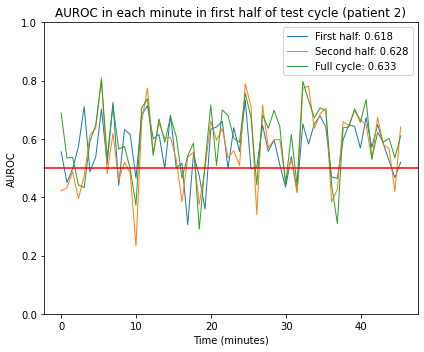

0.8166666666666667

In [426]:
idx = 0

plt.rcParams['figure.figsize']=(6,5)

X_test_partition = X_test_partitions[idx]

model_0 = joblib.load(model_dir + '/cycles/0_924.pkl') # first half
# model_1 = joblib.load(model_dir + '/cycles/1_924.pkl') # first half
# model_1 = joblib.load(model_dir + '/cycles/1_870.pkl') # first half
model_1 = joblib.load(model_dir + '/cycles/1_924.pkl') # first half
model_2 = joblib.load(model_dir + '/cycles/2_924.pkl') # first half

fig = plt.figure()
ax = fig.add_subplot(111)

roc_scores = []
preds = model_0.predict(X_test_partition)

mins = len(y_test_partitions[0]) // 60

for i in range(int(len(y_test_partitions[idx]) / mins)):
    if (y_test_partitions[idx][i * mins:(i+1) * mins] > thresh).sum() == 0:
        roc_scores.append(0.5)
    else:
        roc_scores.append(roc_auc_score(y_test_partitions[idx][i * mins:(i+1) * mins] > thresh, preds[i * mins:(i+1) * mins]))
ax.plot([length * len(y_test_partitions[0]) / 60 / len(roc_scores) for length in range(len(roc_scores))], roc_scores, linewidth=1, label='First half: ' + str(np.around(np.array(cycle_scores).mean(axis=0)[idx::3][0], 3)))

roc_scores = []
preds = model_1.predict(X_test_partition)

for i in range(int(len(y_test_partitions[idx]) / mins)):
    if (y_test_partitions[idx][i * mins:(i+1) * mins] > thresh).sum() == 0:
        roc_scores.append(0.5)
    else:
        roc_scores.append(roc_auc_score(y_test_partitions[idx][i * mins:(i+1) * mins] > thresh, preds[i * mins:(i+1) * mins]))
ax.plot([length * len(y_test_partitions[0]) / 60 / len(roc_scores) for length in range(len(roc_scores))], roc_scores, linewidth=1, label='Second half: ' + str(np.around(np.array(cycle_scores).mean(axis=0)[idx::3][1], 3)))

roc_scores = []
preds = model_2.predict(X_test_partition)

for i in range(int(len(y_test_partitions[idx]) / mins)):
    if (y_test_partitions[idx][i * mins:(i+1) * mins] > thresh).sum() == 0:
        roc_scores.append(0.5)
    else:
        roc_scores.append(roc_auc_score(y_test_partitions[idx][i * mins:(i+1) * mins] > thresh, preds[i * mins:(i+1) * mins]))
ax.plot([length * len(y_test_partitions[0]) / 60 / len(roc_scores) for length in range(len(roc_scores))], roc_scores, linewidth=1, label='Full cycle: ' + str(np.around(np.array(cycle_scores).mean(axis=0)[idx::3][2], 3)))

ax.axhline(y=0.5, color='r', linestyle='-')
ax.set_ylabel('AUROC')
ax.set_xlabel('Time (minutes)')
plt.ylim([0, 1])
plt.legend()
plt.title('AUROC in each minute in first half of test cycle (patient 2)')
plt.tight_layout()
plt.savefig(image_dir + '/auroc_over_time_cycle_1.pdf')

plt.show()
len([roc for roc in roc_scores if roc >= 0.5]) / len(roc_scores)

In [355]:
# BeSa
np.mean(cycle_scores[idx])#.reshape(-1, 3)

0.7086551306357962

77

In [424]:
# BeSa
np.argmax(cycle_scores, axis=0)#.reshape(-1, 3)

array([2, 1, 1, 4, 3, 4, 0, 0, 0])

1) train first, test first
2) train first, test second
3) train first, test all
4) train second, test first
5) train second, test second
6) train second, test all
7) train all, test first
8) train all, test second
9) train all, test all

In [439]:
np.around(np.array(cycle_scores).mean(axis=0), 3).reshape(-1, 3)

array([[0.633, 0.69 , 0.678],
       [0.625, 0.839, 0.751],
       [0.642, 0.853, 0.767]])

In [440]:
np.around(np.array(cycle_scores).std(axis=0), 3).reshape(-1, 3)

array([[0.005, 0.042, 0.027],
       [0.004, 0.01 , 0.005],
       [0.002, 0.002, 0.001]])

In [447]:
np.array(cycle_scores)[:, 6].mean()

0.6419577684414819

In [455]:
np.array(cycle_scores)[:, 0].mean()

0.618446866166445

In [457]:
from scipy.stats import mannwhitneyu
# generate two independent samples
data1 = np.array(cycle_scores)[:, 1]
data2 = np.array(cycle_scores)[:, 4]
# data2 = np.array(main_scores)[4]
# compare samples
stat, p = mannwhitneyu(data1, data2)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distribution (fail to reject H0)')
else:
	print('Different distribution (reject H0)')

Statistics=18.000, p=0.310
Same distribution (fail to reject H0)
